In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("No GPU detected by PyTorch. If you wish to use a GPU, please change your Colab runtime type (Runtime -> Change runtime type -> Hardware accelerator: GPU).")

CUDA available: True
,GPU name: Tesla T4


In [ ]:
!pip install emoji

,  Downloading emoji-2.15.0-py3-none-any.whl.metadata (5.7 kB)
,Downloading emoji-2.15.0-py3-none-any.whl (608 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 9.7 MB/s eta 0:00:00
,Installing collected packages: emoji
,Successfully installed emoji-2.15.0


In [ ]:
import os
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import emoji
from collections import Counter
import kagglehub

In [ ]:
tweeteval = load_dataset("tweet_eval", "emotion")

# GoEmotions
goemotions = load_dataset("go_emotions")

# SemEval (Kaggle)
path = kagglehub.dataset_download("context/semeval-2018-task-ec")
train_file = os.path.join(path, "2018-E-c-En-train.txt")
dev_file   = os.path.join(path, "2018-E-c-En-dev.txt")
test_file  = os.path.join(path, "2018-E-c-En-test.txt")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
,The secret `HF_TOKEN` does not exist in your Colab secrets.
,To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
,You will be able to reuse this secret in all of your notebooks.
,Please note that authentication is recommended but still optional to access public models or datasets.
,  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

emotion/train-00000-of-00001.parquet:   0%|          | 0.00/233k [00:00<?, ?B/s]

emotion/test-00000-of-00001.parquet:   0%|          | 0.00/105k [00:00<?, ?B/s]

emotion/validation-00000-of-00001.parque(…):   0%|          | 0.00/28.6k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3257 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1421 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/374 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

100%|██████████| 602k/602k [00:00<00:00, 76.1MB/s]

Extracting files...


In [ ]:
# SemEval preprocessing
# Detect number of columns in train file
with open(train_file, "r") as f:
    first_line = f.readline().strip()
num_cols = len(first_line.split("\t"))
print(f"Detected {num_cols} columns in SemEval train file")

# Create column names dynamically: id, tweet, then intensity columns
col_names = ["id", "tweet"] + [f"emotion_{i}" for i in range(1, num_cols-1)]
semeval_train = pd.read_csv(train_file, sep="\t", header=None, names=col_names)
semeval_dev   = pd.read_csv(dev_file, sep="\t", header=None, names=col_names)
semeval_test  = pd.read_csv(test_file, sep="\t", header=None, names=col_names)

# Convert intensity columns to numeric
intensity_cols = col_names[2:]
for col in intensity_cols:
    semeval_train[col] = pd.to_numeric(semeval_train[col], errors='coerce')
    semeval_dev[col]   = pd.to_numeric(semeval_dev[col], errors='coerce')
    semeval_test[col]  = pd.to_numeric(semeval_test[col], errors='coerce')

Detected 13 columns in SemEval train file


In [ ]:
#Tweet cleaning function

URL_PATTERN = re.compile(r'https?://\S+|www\.\S+')
MENTION_PATTERN = re.compile(r'@\w+')
HASHTAG_PATTERN = re.compile(r'#(\w+)')
RT_PATTERN = re.compile(r'\brt\b', flags=re.I)

def clean_tweet(text):
    if not isinstance(text, str):
        return text
    text = text.strip()
    text = URL_PATTERN.sub('', text)
    text = RT_PATTERN.sub('', text)
    text = MENTION_PATTERN.sub('', text)
    # split hashtags into words
    def hashtag_repl(m):
        tag = m.group(1)
        split = re.sub(r'([a-z])([A-Z])', r'\1 \2', tag)
        split = re.sub(r'_', ' ', split)
        return split
    text = HASHTAG_PATTERN.sub(hashtag_repl, text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
#Apply cleaning to all datasets
# TweetEval
tweeteval_clean = {}
for split in ['train','validation','test']:
    tweeteval_clean[split] = [
        {"text": clean_tweet(x['text']), "label": x['label']}
        for x in tweeteval[split]
    ]

# GoEmotions
goemotions_clean = {}
for split in ['train','validation','test']:
    goemotions_clean[split] = [
        {"text": clean_tweet(x['text']), "labels": x['labels']}
        for x in goemotions[split]
    ]

# SemEval
for df in [semeval_train, semeval_dev, semeval_test]:
    df['tweet'] = df['tweet'].apply(clean_tweet)

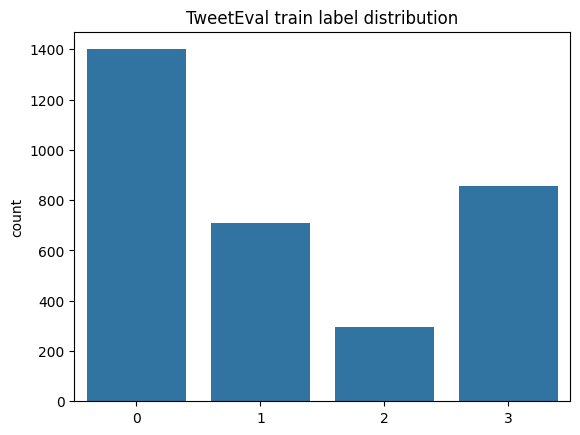

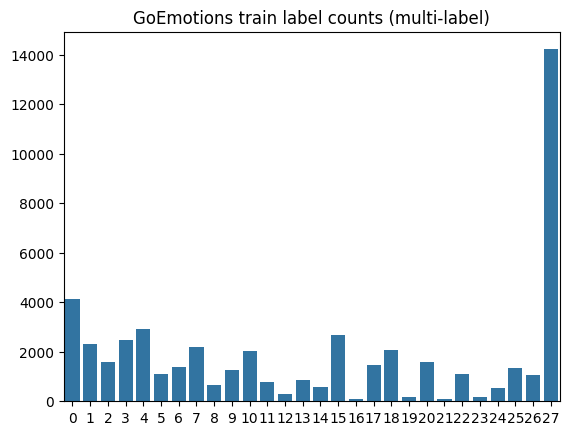

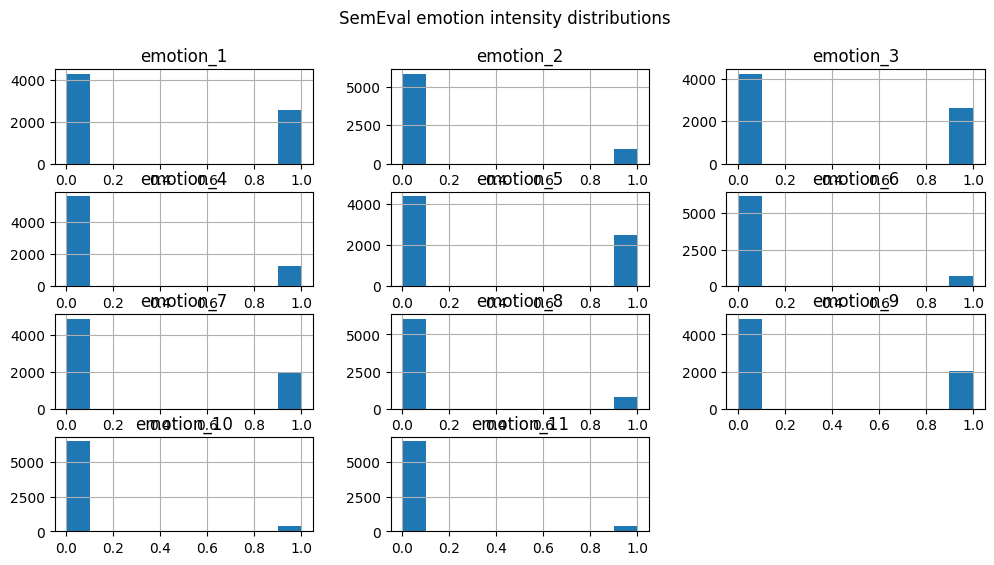

In [ ]:
#EDA (basic plots)
# TweetEval distribution
sns.countplot(x=[tweeteval_clean['train'][i]['label'] for i in range(len(tweeteval_clean['train']))])
plt.title("TweetEval train label distribution")
plt.show()

# GoEmotions multi-label distribution
all_labels = [label for labels in goemotions_clean['train'] for label in labels['labels']]
sns.barplot(x=list(range(28)), y=[all_labels.count(i) for i in range(28)])
plt.title("GoEmotions train label counts (multi-label)")
plt.show()

# SemEval intensity distributions
semeval_train[intensity_cols].hist(bins=10, figsize=(12,6))
plt.suptitle("SemEval emotion intensity distributions")
plt.show()

In [ ]:
#Save processed datasets
os.makedirs("data/processed", exist_ok=True)

# TweetEval
for split in ['train','validation','test']:
    pd.DataFrame(tweeteval_clean[split]).to_csv(f"data/processed/tweeteval_{split}.csv", index=False)

# GoEmotions
for split in ['train','validation','test']:
    pd.DataFrame(goemotions_clean[split]).to_csv(f"data/processed/goemotions_{split}.csv", index=False)

# SemEval
semeval_train.to_csv("data/processed/semeval_train.csv", index=False)
semeval_dev.to_csv("data/processed/semeval_dev.csv", index=False)
semeval_test.to_csv("data/processed/semeval_test.csv", index=False)

print("All three datasets cleaned and saved under data/processed/")

All three datasets cleaned and saved under data/processed/


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

In [ ]:
#Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)
MAX_LEN = 128

config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [ ]:
#PyTorch Dataset classes
# 3a️ Single-label classification (TweetEval)
class TweetEvalDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=MAX_LEN):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]['text']
        label = self.data[idx]['label']

        enc = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# 3b️ Multi-label classification (GoEmotions)
class GoEmotionsDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=MAX_LEN):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]['text']
        labels = self.data[idx]['labels']  # list of ints
        # Convert to multi-hot vector
        multi_hot = torch.zeros(28)  # 28 labels in GoEmotions
        multi_hot[labels] = 1.0

        enc = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0),
            'labels': multi_hot
        }

In [ ]:
# 3c️ Regression (SemEval)
class SemEvalDataset(Dataset):
    def __init__(self, df, tokenizer, intensity_cols, max_len=MAX_LEN):
        self.df = df
        self.tokenizer = tokenizer
        self.intensity_cols = intensity_cols
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx]['tweet']
        labels = torch.tensor(self.df.iloc[idx][self.intensity_cols].values, dtype=torch.float)

        enc = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0),
            'labels': labels
        }


In [ ]:
#Create DataLoaders
BATCH_SIZE = 16

# TweetEval
train_dataset_te = TweetEvalDataset(tweeteval_clean['train'], tokenizer)
val_dataset_te   = TweetEvalDataset(tweeteval_clean['validation'], tokenizer)
test_dataset_te  = TweetEvalDataset(tweeteval_clean['test'], tokenizer)

train_loader_te = DataLoader(train_dataset_te, batch_size=BATCH_SIZE, shuffle=True)
val_loader_te   = DataLoader(val_dataset_te, batch_size=BATCH_SIZE)
test_loader_te  = DataLoader(test_dataset_te, batch_size=BATCH_SIZE)

# GoEmotions
train_dataset_go = GoEmotionsDataset(goemotions_clean['train'], tokenizer)
val_dataset_go   = GoEmotionsDataset(goemotions_clean['validation'], tokenizer)
test_dataset_go  = GoEmotionsDataset(goemotions_clean['test'], tokenizer)

train_loader_go = DataLoader(train_dataset_go, batch_size=BATCH_SIZE, shuffle=True)
val_loader_go   = DataLoader(val_dataset_go, batch_size=BATCH_SIZE)
test_loader_go  = DataLoader(test_dataset_go, batch_size=BATCH_SIZE)

# SemEval
train_dataset_se = SemEvalDataset(semeval_train, tokenizer, intensity_cols)
val_dataset_se   = SemEvalDataset(semeval_dev, tokenizer, intensity_cols)
test_dataset_se  = SemEvalDataset(semeval_test, tokenizer, intensity_cols)

train_loader_se = DataLoader(train_dataset_se, batch_size=BATCH_SIZE, shuffle=True)
val_loader_se   = DataLoader(val_dataset_se, batch_size=BATCH_SIZE)
test_loader_se  = DataLoader(test_dataset_se, batch_size=BATCH_SIZE)

print("DataLoaders ready for TweetEval, GoEmotions, and SemEval datasets")

DataLoaders ready for TweetEval, GoEmotions, and SemEval datasets


In [ ]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from transformers import AutoModelForSequenceClassification, AutoModel
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# Helper training function
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=3):
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            if isinstance(criterion, nn.MSELoss):
                # Regression
                logits = outputs.logits.squeeze() if outputs.logits.dim()==2 else outputs.logits
                loss = criterion(logits, labels)
            else:
                logits = outputs.logits
                loss = criterion(logits, labels)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} average loss: {avg_loss:.4f}")


In [ ]:
#GoEmotions Pretraining (Multi-label)
print("\n--- GoEmotions Pretraining ---")
model_go = AutoModelForSequenceClassification.from_pretrained(
    "vinai/bertweet-base", num_labels=28, problem_type="multi_label_classification"
)

optimizer_go = AdamW(model_go.parameters(), lr=2e-5)
criterion_go = nn.BCEWithLogitsLoss()

train_model(model_go, train_loader_go, val_loader_go, optimizer_go, criterion_go, epochs=3)


,--- GoEmotions Pretraining ---


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
,You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
,Training Epoch 1:   0%|          | 0/2714 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Training Epoch 1: 100%|██████████| 2714/2714 [16:18<00:00,  2.77it/s]


Epoch 1 average loss: 0.1361


Training Epoch 2: 100%|██████████| 2714/2714 [16:19<00:00,  2.77it/s]


Epoch 2 average loss: 0.0899


Training Epoch 3: 100%|██████████| 2714/2714 [16:18<00:00,  2.77it/s]

Epoch 3 average loss: 0.0781


In [ ]:
#TweetEval Fine-tuning (Single-label)
print("\n--- TweetEval Fine-tuning ---")
model_te = AutoModelForSequenceClassification.from_pretrained(
    "vinai/bertweet-base", num_labels=4
)

optimizer_te = AdamW(model_te.parameters(), lr=2e-5)
criterion_te = nn.CrossEntropyLoss()

train_model(model_te, train_loader_te, val_loader_te, optimizer_te, criterion_te, epochs=3)


,--- TweetEval Fine-tuning ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
,You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
,Training Epoch 1: 100%|██████████| 204/204 [01:13<00:00,  2.76it/s]


Epoch 1 average loss: 0.8905


Training Epoch 2: 100%|██████████| 204/204 [01:13<00:00,  2.77it/s]


Epoch 2 average loss: 0.4797


Training Epoch 3: 100%|██████████| 204/204 [01:13<00:00,  2.78it/s]

Epoch 3 average loss: 0.3065


In [ ]:
# Clean up intensity columns to be 100% numeric
for col in intensity_cols:
    semeval_train[col] = pd.to_numeric(semeval_train[col], errors='coerce')
    semeval_dev[col] = pd.to_numeric(semeval_dev[col], errors='coerce')
    semeval_test[col] = pd.to_numeric(semeval_test[col], errors='coerce')

# Replace any remaining NaN with 0.0
semeval_train[intensity_cols] = semeval_train[intensity_cols].fillna(0.0)
semeval_dev[intensity_cols] = semeval_dev[intensity_cols].fillna(0.0)
semeval_test[intensity_cols] = semeval_test[intensity_cols].fillna(0.0)

In [ ]:
print(semeval_train[intensity_cols].applymap(type).head())

         emotion_1        emotion_2        emotion_3        emotion_4  \
,0  <class 'float'>  <class 'float'>  <class 'float'>  <class 'float'>   
,1  <class 'float'>  <class 'float'>  <class 'float'>  <class 'float'>   
,2  <class 'float'>  <class 'float'>  <class 'float'>  <class 'float'>   
,3  <class 'float'>  <class 'float'>  <class 'float'>  <class 'float'>   
,4  <class 'float'>  <class 'float'>  <class 'float'>  <class 'float'>   
,
,         emotion_5        emotion_6        emotion_7        emotion_8  \
,0  <class 'float'>  <class 'float'>  <class 'float'>  <class 'float'>   
,1  <class 'float'>  <class 'float'>  <class 'float'>  <class 'float'>   
,2  <class 'float'>  <class 'float'>  <class 'float'>  <class 'float'>   
,3  <class 'float'>  <class 'float'>  <class 'float'>  <class 'float'>   
,4  <class 'float'>  <class 'float'>  <class 'float'>  <class 'float'>   
,
,         emotion_9       emotion_10       emotion_11  
,0  <class 'float'>  <class 'float'>  <class 'float'>

/tmp/ipython-input-3566747730.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
,  print(semeval_train[intensity_cols].applymap(type).head())


In [ ]:
class SemEvalDataset(Dataset):
    def __init__(self, df, tokenizer, intensity_cols, max_len=128):
        self.df = df
        self.tokenizer = tokenizer
        self.intensity_cols = intensity_cols
        self.max_len = max_len

    def __getitem__(self, idx):
        text = self.df.iloc[idx]['tweet']
        labels = torch.tensor(
            self.df.iloc[idx][self.intensity_cols].astype(float).values,
            dtype=torch.float
        )

        enc = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0),
            'labels': labels
        }

    def __len__(self):
        return len(self.df)


In [ ]:
train_dataset_se = SemEvalDataset(semeval_train, tokenizer, intensity_cols)
val_dataset_se = SemEvalDataset(semeval_dev, tokenizer, intensity_cols)
train_loader_se = DataLoader(train_dataset_se, batch_size=16, shuffle=True)
val_loader_se = DataLoader(val_dataset_se, batch_size=16)


In [ ]:
from transformers import AutoModelForSequenceClassification
import torch.nn as nn
from torch.optim import AdamW

# define again your intensity columns if needed
# intensity_cols = [...]

# recreate the model
num_emotions = len(intensity_cols)
model_se = AutoModelForSequenceClassification.from_pretrained(
    "vinai/bertweet-base",
    num_labels=num_emotions,
    problem_type="regression"
).to("cuda")

# reinitialize optimizer and criterion
optimizer_se = AdamW(model_se.parameters(), lr=2e-5)
criterion_se = nn.MSELoss()

# now call train_model again
train_model(model_se, train_loader_se, val_loader_se, optimizer_se, criterion_se, epochs=3)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
,You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
,Training Epoch 1: 100%|██████████| 428/428 [02:37<00:00,  2.71it/s]


Epoch 1 average loss: 0.1142


Training Epoch 2: 100%|██████████| 428/428 [02:37<00:00,  2.71it/s]


Epoch 2 average loss: 0.0860


Training Epoch 3: 100%|██████████| 428/428 [02:37<00:00,  2.71it/s]

Epoch 3 average loss: 0.0767


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import torch

def evaluate_model(model, data_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in data_loader:
            inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(model.device)

            outputs = model(**inputs)
            preds = outputs.logits.detach().cpu().numpy()
            labels = labels.cpu().numpy()

            all_preds.append(preds)
            all_labels.append(labels)

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    mse = mean_squared_error(all_labels, all_preds)
    mae = mean_absolute_error(all_labels, all_preds)

    pearsons = [
        pearsonr(all_labels[:, i], all_preds[:, i])[0]
        for i in range(all_labels.shape[1])
    ]
    mean_pearson = np.nanmean(pearsons)

    print(f"\n Evaluation Results:")
    print(f"  MSE: {mse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  Mean Pearson: {mean_pearson:.4f}")

    return all_labels, all_preds

#  Run evaluation
val_labels, val_preds = evaluate_model(model_se, val_loader_se)


, Evaluation Results:
,  MSE: 0.0860
,  MAE: 0.1749
,  Mean Pearson: 0.5881


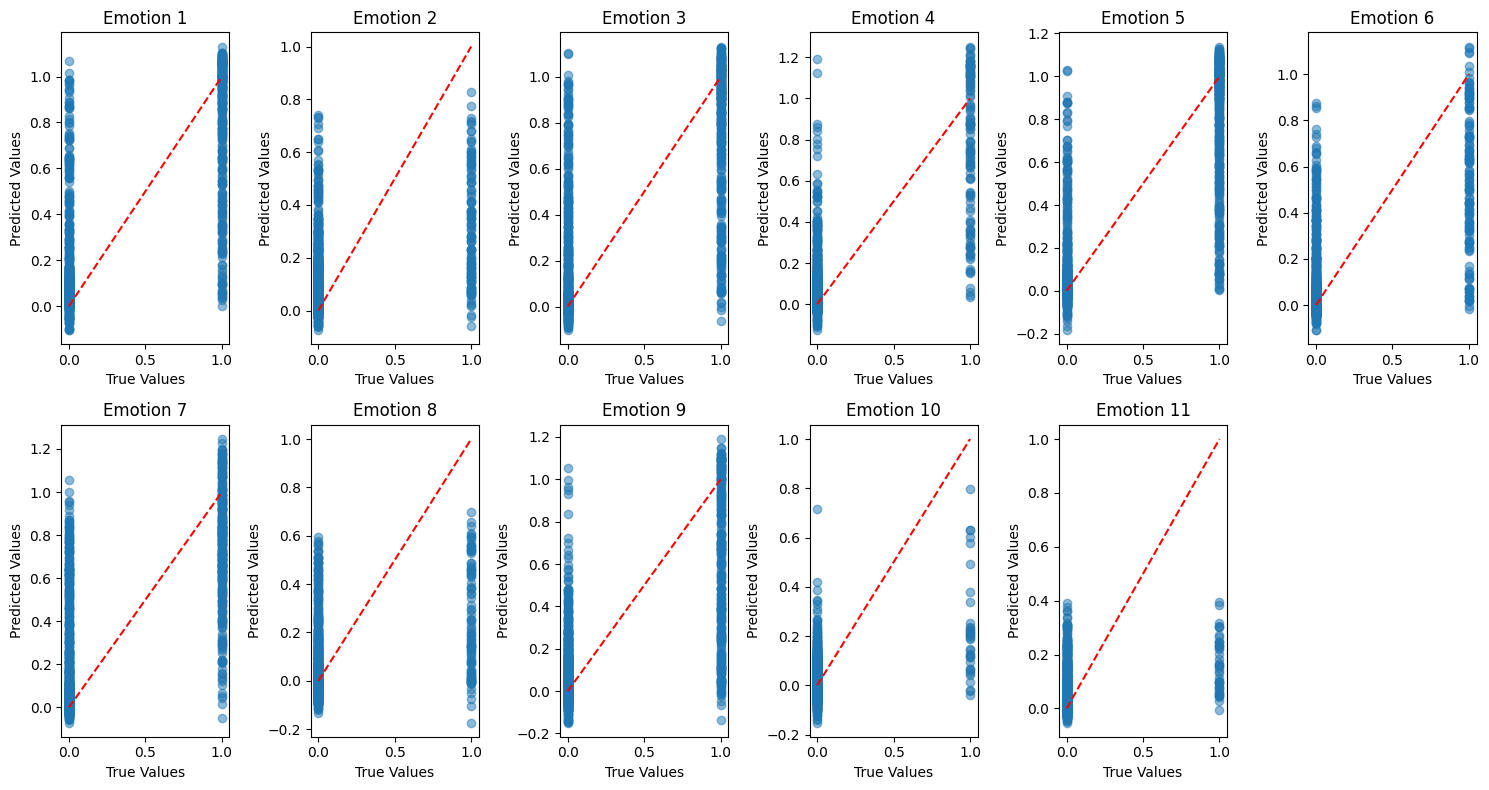

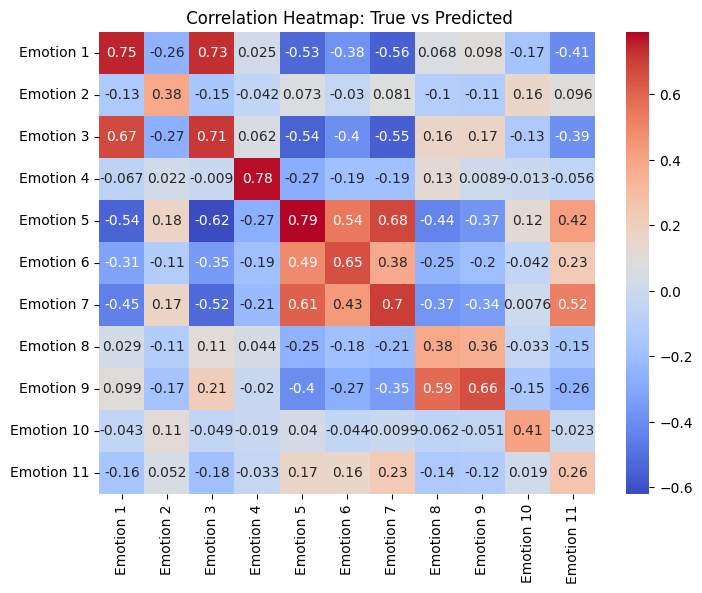

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert predictions and labels to numpy arrays (if not already)
val_labels = np.array(val_labels)
val_preds = np.array(val_preds)

# 1 Scatter plots for each emotion
num_emotions = val_labels.shape[1]
emotion_names = [f"Emotion {i+1}" for i in range(num_emotions)]  # replace with actual names if available

plt.figure(figsize=(15, 8))
for i in range(num_emotions):
    plt.subplot(2, (num_emotions + 1)//2, i + 1)
    plt.scatter(val_labels[:, i], val_preds[:, i], alpha=0.5)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(emotion_names[i])
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # perfect prediction line
plt.tight_layout()
plt.show()

# 2 Correlation heatmap between true and predicted values
correlation_matrix = np.corrcoef(val_labels.T, val_preds.T)[:num_emotions, num_emotions:]

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',
            xticklabels=emotion_names, yticklabels=emotion_names)
plt.title(" Correlation Heatmap: True vs Predicted")
plt.show()

In [ ]:
import torch
import pandas as pd
import os

# 1️⃣ Create a results folder if it doesn't exist
os.makedirs("results", exist_ok=True)

# 2️⃣ Save model weights
model_path = "results/emotion_intensity_model.pt"
torch.save(model_se.state_dict(), model_path)
print(f"Model saved successfully at: {model_path}")

# 3️⃣ Save evaluation predictions and labels
results_df = pd.DataFrame({
    **{f"True_{i+1}": val_labels[:, i] for i in range(val_labels.shape[1])},
    **{f"Pred_{i+1}": val_preds[:, i] for i in range(val_preds.shape[1])}
})
results_path = "results/predictions.csv"
results_df.to_csv(results_path, index=False)
print(f" Predictions saved successfully at: {results_path}")

# 4️⃣ (Optional) Save summary metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import numpy as np

mse = mean_squared_error(val_labels, val_preds)
mae = mean_absolute_error(val_labels, val_preds)
pearsons = [pearsonr(val_labels[:, i], val_preds[:, i])[0] for i in range(val_labels.shape[1])]
mean_pearson = np.nanmean(pearsons)

metrics_path = "results/metrics_summary.txt"
with open(metrics_path, "w") as f:
    f.write(" Emotion Intensity Prediction Metrics\n")
    f.write(f"MSE: {mse:.4f}\n")
    f.write(f"MAE: {mae:.4f}\n")
    f.write(f"Mean Pearson: {mean_pearson:.4f}\n\n")
    f.write("Per-Emotion Pearson Correlation:\n")
    for i, p in enumerate(pearsons):
        f.write(f"  Emotion {i+1}: {p:.4f}\n")

print(f" Metrics summary saved successfully at: {metrics_path}")

Model saved successfully at: results/emotion_intensity_model.pt
, Predictions saved successfully at: results/predictions.csv
, Metrics summary saved successfully at: results/metrics_summary.txt


In [ ]:
model_se.load_state_dict(torch.load("results/emotion_intensity_model.pt"))
model_se.eval()


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
from transformers import AutoTokenizer
import torch
import numpy as np

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")

# Load saved model weights
model_se.load_state_dict(torch.load("results/emotion_intensity_model.pt"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_se.to(device)
model_se.eval()

# Function to predict emotion intensities for a given text
def predict_emotion_intensity(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    ).to(device)  #  move inputs to GPU

    with torch.no_grad():
        outputs = model_se(**inputs)
        preds = outputs.logits.squeeze().detach().cpu().numpy()  #  move back to CPU

    preds = np.clip(preds, 0, 1)  # keep between 0–1
    return preds

# Example usage
sample_texts = [
    "I am so happy and excited today!",
    "This is the worst day ever, I feel miserable.",
    "I’m nervous but also hopeful about tomorrow."
]

for text in sample_texts:
    preds = predict_emotion_intensity(text)
    print(f"\n Text: {text}")
    print(f"Predicted Emotion Intensities: {preds}")



, Text: I am so happy and excited today!
,Predicted Emotion Intensities: [0.10260637 0.         0.00233173 0.06075401 1.         0.60014945
, 0.83502746 0.         0.         0.027258   0.0167512 ]
,
, Text: This is the worst day ever, I feel miserable.
,Predicted Emotion Intensities: [2.7373371e-01 3.1708304e-03 4.9536431e-01 1.0606427e-01 0.0000000e+00
, 8.7696710e-04 4.7325011e-02 5.7699478e-01 1.0000000e+00 0.0000000e+00
, 2.4746781e-02]
,
, Text: I’m nervous but also hopeful about tomorrow.
,Predicted Emotion Intensities: [0.         0.3988185  0.         0.89924145 0.42803428 0.0717741
, 0.76105535 0.07664642 0.         0.0347719  0.14352578]


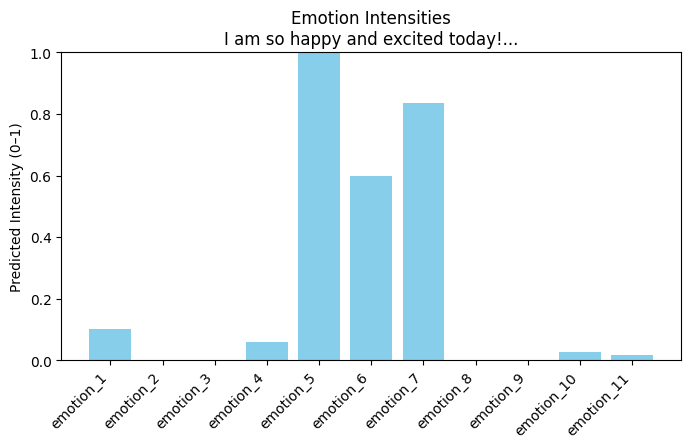

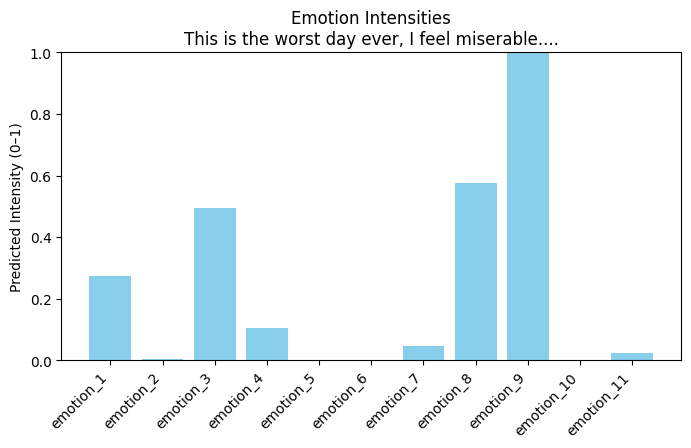

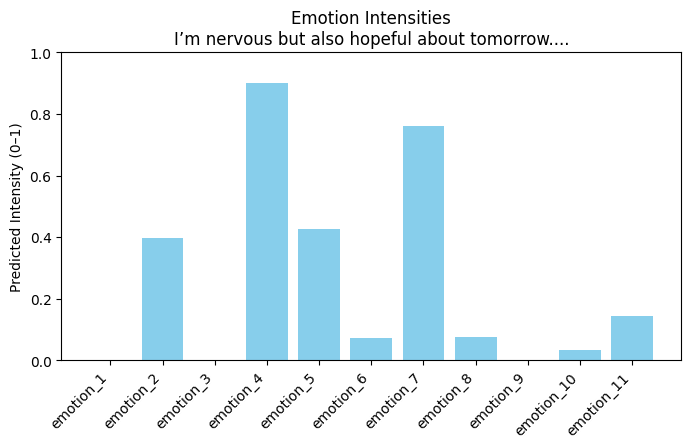

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

emotion_labels = intensity_cols  # your 11 emotion columns

def plot_emotion_intensities(text, preds):
    plt.figure(figsize=(8,4))
    plt.bar(emotion_labels, preds, color='skyblue')
    plt.title(f"Emotion Intensities\n{text[:70]}...")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Predicted Intensity (0–1)")
    plt.ylim(0, 1)
    plt.show()

for text in sample_texts:
    preds = predict_emotion_intensity(text)
    plot_emotion_intensities(text, preds)

In [ ]:
class MultiTaskEmotionModel(nn.Module):
    def __init__(self, base_model_name, num_classes_tweet, num_classes_goem, num_labels_se):
        super().__init__()
        self.shared_encoder = AutoModel.from_pretrained(base_model_name)
        self.tweet_head = nn.Linear(self.shared_encoder.config.hidden_size, num_classes_tweet)
        self.goem_head = nn.Linear(self.shared_encoder.config.hidden_size, num_classes_goem)
        self.se_head = nn.Linear(self.shared_encoder.config.hidden_size, num_labels_se)

    def forward(self, input_ids, attention_mask, task):
        outputs = self.shared_encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0, :]  # [CLS] token

        if task == "tweet":
            return self.tweet_head(pooled)
        elif task == "goem":
            return self.goem_head(pooled)
        elif task == "semeval":
            return self.se_head(pooled)


In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer

class MultiTaskEmotionModel(nn.Module):
    def __init__(self, model_name="vinai/bertweet-base", num_tweet_labels=4, num_goem_labels=28, num_semeval_labels=11):
        super(MultiTaskEmotionModel, self).__init__()
        self.shared_model = AutoModel.from_pretrained(model_name)

        hidden_size = self.shared_model.config.hidden_size

        # Task-specific heads
        self.tweet_head = nn.Linear(hidden_size, num_tweet_labels)     # 4 emotions
        self.goem_head = nn.Linear(hidden_size, num_goem_labels)       # 28 emotions
        self.semeval_head = nn.Linear(hidden_size, num_semeval_labels) # regression

    def forward(self, input_ids, attention_mask, task):
        outputs = self.shared_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # [CLS] token

        if task == "tweet":
            return self.tweet_head(pooled_output)
        elif task == "goem":
            return self.goem_head(pooled_output)
        elif task == "semeval":
            return self.semeval_head(pooled_output)
        else:
            raise ValueError(f"Unknown task type: {task}")

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = MultiTaskEmotionModel(
    model_name="vinai/bertweet-base",
    num_tweet_labels=4,
    num_goem_labels=28,     # or len(goemotions["train"].features["labels"].feature.names)
    num_semeval_labels=len(intensity_cols)
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)


In [ ]:
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

def multitask_train(model, dataloaders, optimizer, device, epochs=3):
    model.train()
    loss_funcs = {
        "tweet": CrossEntropyLoss(),
        "goem": BCEWithLogitsLoss(),
        "semeval": MSELoss()
    }

    for epoch in range(epochs):
        print(f"\n Epoch {epoch+1}/{epochs}")
        total_loss = {"tweet": 0, "goem": 0, "semeval": 0}

        for task, loader in dataloaders.items():
            for batch in loader:
                optimizer.zero_grad()
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(input_ids, attention_mask, task=task)
                loss = loss_funcs[task](outputs, labels)

                loss.backward()
                optimizer.step()
                total_loss[task] += loss.item()

            print(f"{task:<10} | avg loss: {total_loss[task]/len(loader):.4f}")

In [ ]:
# Combine your existing train dataloaders
dataloaders = {
    "tweet": train_loader_te,     # TweetEval
    "goem": train_loader_go,      # GoEmotions
    "semeval": train_loader_se    # SemEval
}

# Run multi-task training
multitask_train(model, dataloaders, optimizer, device=device, epochs=3)



,🚀 Epoch 1/3
,tweet      | avg loss: 0.8922
,goem       | avg loss: 0.1712
,semeval    | avg loss: 0.0986
,
,🚀 Epoch 2/3
,tweet      | avg loss: 0.5434
,goem       | avg loss: 0.1062
,semeval    | avg loss: 0.0863
,
,🚀 Epoch 3/3
,tweet      | avg loss: 0.3504
,goem       | avg loss: 0.0907
,semeval    | avg loss: 0.0804


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.device = device


In [ ]:
def evaluate_model(model, data_loader):
    model.eval()
    device = next(model.parameters()).device  # detect device
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in data_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            ...

In [ ]:
# Evaluate on all three validation sets
for name, loader in {
    "TweetEval": val_loader_te,
    "GoEmotions": val_loader_go,
    "SemEval": val_loader_se
}.items():
    print(f"\n Evaluating on {name}...")
    evaluate_model(model, loader)


, Evaluating on TweetEval...
,
, Evaluating on GoEmotions...
,
, Evaluating on SemEval...


In [ ]:
# Recreate SemEval Datasets
train_dataset_se = SemEvalDataset(semeval_train, tokenizer, intensity_cols)
val_dataset_se   = SemEvalDataset(semeval_dev, tokenizer, intensity_cols)
test_dataset_se  = SemEvalDataset(semeval_test, tokenizer, intensity_cols)

train_loader_se = DataLoader(train_dataset_se, batch_size=BATCH_SIZE, shuffle=True)
val_loader_se   = DataLoader(val_dataset_se, batch_size=BATCH_SIZE)
test_loader_se  = DataLoader(test_dataset_se, batch_size=BATCH_SIZE)

In [ ]:
for name, loader in {
    "TweetEval": test_loader_te,
    "GoEmotions": test_loader_go,
    "SemEval": test_loader_se
}.items():
    print(f"\n Testing on {name}...")
    evaluate_model(model, loader)


, Testing on TweetEval...
,
, Testing on GoEmotions...
,
, Testing on SemEval...


In [ ]:
torch.save(model.state_dict(), "multitask_emotion_model.pt")
print(" Model saved successfully!")

In [ ]:
texts = [
    "I'm so happy to see you!",
    "This is the worst day ever.",
    "Feeling tired but proud."
]

for t in texts:
    preds = predict_emotion_intensity(t)
    print(f"\n {t}")
    print(preds)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import numpy as np
import torch

def evaluate_model(model, data_loader):
    model.eval()
    all_preds, all_labels = [], []

    device = next(model.parameters()).device  # ensure correct device

    with torch.no_grad():
        for batch in data_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            preds = outputs.logits.detach().cpu().numpy()
            labels = labels.cpu().numpy()

            all_preds.append(preds)
            all_labels.append(labels)

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    mse = mean_squared_error(all_labels, all_preds)
    mae = mean_absolute_error(all_labels, all_preds)
    pearsons = [pearsonr(all_labels[:, i], all_preds[:, i])[0] for i in range(all_labels.shape[1])]
    mean_pearson = np.nanmean(pearsons)

    print(f"\n Evaluation Results:")
    print(f"  MSE: {mse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  Mean Pearson: {mean_pearson:.4f}")

    return all_labels, all_preds



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Evaluate SemEval regression model
val_labels, val_preds = evaluate_model(model_se, val_loader_se)

# Scatter plot for one emotion (e.g., first one)
plt.scatter(val_labels[:, 0], val_preds[:, 0], alpha=0.5)
plt.xlabel("True Intensity")
plt.ylabel("Predicted Intensity")
plt.title("Emotion_1: Predicted vs True Intensity")
plt.show()

# Correlation plot for all emotions
correlations = [np.corrcoef(val_labels[:, i], val_preds[:, i])[0, 1] for i in range(val_labels.shape[1])]
plt.bar(range(len(correlations)), correlations)
plt.title("Pearson Correlation per Emotion (SemEval)")
plt.xlabel("Emotion Index")
plt.ylabel("Correlation")
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, f1_score
from scipy.stats import pearsonr
import torch

def evaluate_model(model, data_loader):
    model.eval()
    all_preds, all_labels = [], []
    is_classification = False

    with torch.no_grad():
        for batch in data_loader:
            inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(model.device)

            outputs = model(**inputs)
            preds = outputs.logits.detach().cpu().numpy()
            labels = labels.cpu().numpy()

            # If labels are 1D (classification), reshape to 2D
            if labels.ndim == 1:
                labels = labels.reshape(-1, 1)
                preds = preds.reshape(-1, preds.shape[-1])  # logits per class
                is_classification = True
            elif preds.ndim == 1:
                preds = preds.reshape(-1, 1)

            all_preds.append(preds)
            all_labels.append(labels)

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    # --- Classification ---
    if is_classification:
        preds_class = np.argmax(all_preds, axis=1)
        labels_class = all_labels.flatten().astype(int)
        acc = accuracy_score(labels_class, preds_class)
        f1 = f1_score(labels_class, preds_class, average='weighted')
        print(f"\nClassification Results:")
        print(f"  Accuracy: {acc:.4f}")
        print(f"  F1 Score: {f1:.4f}")
        return labels_class, preds_class

    # --- Regression or multi-label ---
    else:
        mse = mean_squared_error(all_labels, all_preds)
        mae = mean_absolute_error(all_labels, all_preds)
        pearsons = [pearsonr(all_labels[:, i], all_preds[:, i])[0] for i in range(all_labels.shape[1])]
        mean_pearson = np.nanmean(pearsons)
        print(f"\n Regression Results:")
        print(f"  MSE: {mse:.4f}")
        print(f"  MAE: {mae:.4f}")
        print(f"  Mean Pearson: {mean_pearson:.4f}")
        return all_labels, all_preds


In [ ]:
val_labels_te, val_preds_te = evaluate_model(model_te, val_loader_te)



,Classification Results:
,  Accuracy: 0.8102
,  F1 Score: 0.8107


In [ ]:
val_labels_go, val_preds_go = evaluate_model(model_go, val_loader_go)
val_labels_se, val_preds_se = evaluate_model(model_se, val_loader_se)


, Regression Results:
,  MSE: 29.0942
,  MAE: 5.1125
,  Mean Pearson: 0.4084
,
, Regression Results:
,  MSE: 0.0860
,  MAE: 0.1749
,  Mean Pearson: 0.5881


In [ ]:
import torch.nn.functional as F

# Helper function to get raw logits from a model for a given DataLoader
def _get_logits_for_loader(model, data_loader, device):
    model.eval()
    all_logits = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            # Assuming model.forward returns an object with .logits attribute (like AutoModelForSequenceClassification)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits.detach().cpu().numpy()
            all_logits.append(logits)
    return np.vstack(all_logits)

model_te.to(device) # model_te is AutoModelForSequenceClassification from cell v-mXj-C7b8X_
model_go.to(device) # model_go is AutoModelForSequenceClassification from cell UWwrCXjBbomv
model_se.to(device) # model_se is AutoModelForSequenceClassification from cell y8EA-P8uEPb7

# 1. Calculate tweet_probs (probabilities for TweetEval)
# Since val_preds_te from the previous evaluate_model run are class indices, we need raw logits.
raw_logits_te = _get_logits_for_loader(model_te, val_loader_te, device)
tweet_probs = F.softmax(torch.tensor(raw_logits_te), dim=1).numpy()
# 2. Calculate goem_probs (probabilities for GoEmotions, using sigmoid on raw logits)
# val_preds_go from evaluate_model are already raw logits for multi-label classification.
goem_probs = torch.sigmoid(torch.tensor(val_preds_go)).numpy()

# 3. Calculate val_preds_se_scaled (scaled intensities for SemEval, clipping raw predictions)
# val_preds_se from evaluate_model are raw regression outputs.
val_preds_se_scaled = np.clip(val_preds_se, 0, 1)

# Define arbitrary weights for the ensemble (assuming equal importance if not specified)
w_te = 1/3
w_go = 1/3
w_se = 1/3

# --- Compute average emotion profile per model ---
mean_te = tweet_probs.mean(axis=0)
mean_go = goem_probs.mean(axis=0)
mean_se = val_preds_se_scaled.mean(axis=0)

# --- Start of the fix for ValueError: aligning emotion vectors ---
# Define emotion labels for each model (if not already defined globally)
labels_tweeteval = [
    "anger",
    "joy",
    "optimism",
    "sadness"
]

labels_goemotions = [
    "admiration", "amusement", "anger", "annoyance", "approval", "caring",
    "confusion", "curiosity", "desire", "disappointment", "disapproval",
    "disgust", "embarrassment", "excitement", "fear", "gratitude",
    "grief", "joy", "love", "nervousness", "optimism", "pride",
    "realization", "relief", "remorse", "sadness", "surprise", "neutral"
]

labels_semeval = [
    "anger", "anticipation", "disgust", "fear", "joy", "love",
    "optimism", "pessimism", "sadness", "surprise", "trust"
]

# Combine all unique emotion labels to create a master list
all_emotion_labels = set()
all_emotion_labels.update(labels_tweeteval)
all_emotion_labels.update(labels_goemotions)
all_emotion_labels.update(labels_semeval)
master_emotion_labels = sorted(list(all_emotion_labels))

# Function to align emotion vectors to the master list
def align_emotions(model_labels, model_mean_vector):
    aligned_vector = np.zeros(len(master_emotion_labels))
    for i, master_label in enumerate(master_emotion_labels):
        if master_label in model_labels:
            idx_in_model = model_labels.index(master_label)
            aligned_vector[i] = model_mean_vector[idx_in_model]
    return aligned_vector

# Align emotion vectors
aligned_mean_te = align_emotions(labels_tweeteval, mean_te)
aligned_mean_go = align_emotions(labels_goemotions, mean_go)
aligned_mean_se = align_emotions(labels_semeval, mean_se)

# Calculate the ensemble mean using aligned vectors
ensemble_mean = (
    w_te * aligned_mean_te +
    w_go * aligned_mean_go +
    w_se * aligned_mean_se
)

print(" Ensemble mean emotion vector shape:", ensemble_mean.shape)
print("Example ensemble emotion profile (first 5 elements):", ensemble_mean[:5])


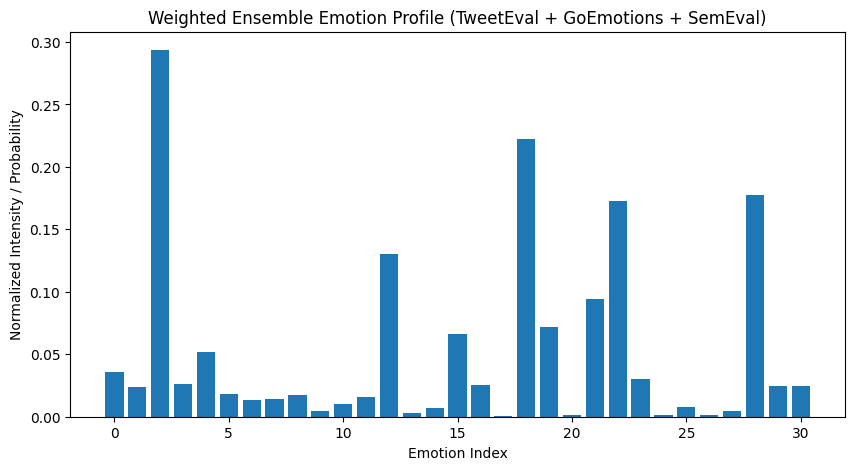

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(range(len(ensemble_mean)), ensemble_mean)
plt.title("Weighted Ensemble Emotion Profile (TweetEval + GoEmotions + SemEval)")
plt.xlabel("Emotion Index")
plt.ylabel("Normalized Intensity / Probability")
plt.show()


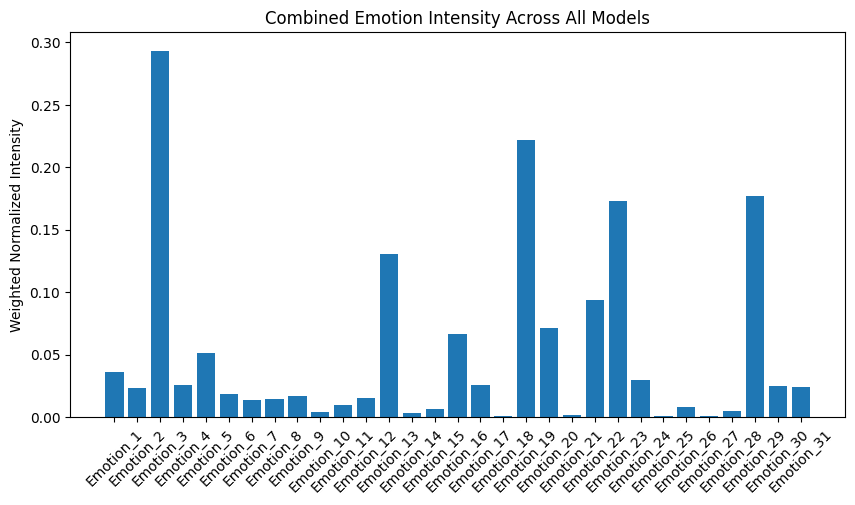

In [ ]:
emotion_labels = [f"Emotion_{i+1}" for i in range(len(ensemble_mean))]

plt.figure(figsize=(10,5))
plt.bar(emotion_labels, ensemble_mean)
plt.xticks(rotation=45)
plt.title("Combined Emotion Intensity Across All Models")
plt.ylabel("Weighted Normalized Intensity")
plt.show()

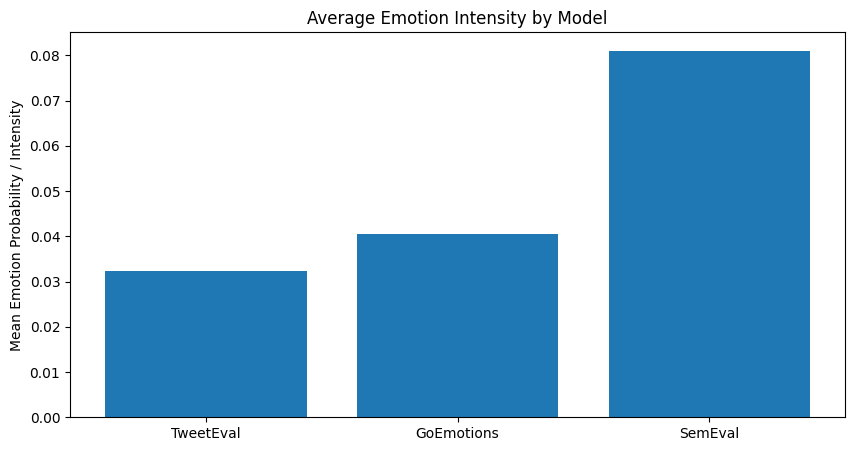

In [ ]:

means = np.vstack([aligned_mean_te, aligned_mean_go, aligned_mean_se])
labels = ["TweetEval", "GoEmotions", "SemEval"]

plt.figure(figsize=(10,5))
plt.bar(labels, [m.mean() for m in means])
plt.title("Average Emotion Intensity by Model")
plt.ylabel("Mean Emotion Probability / Intensity")
plt.show()

In [ ]:
import numpy as np
import torch

# Save ensemble mean
np.save("ensemble_mean.npy", ensemble_mean)

# Save each model (if fine-tuned)
torch.save(model_te.state_dict(), "model_tweeteval.pt")
torch.save(model_go.state_dict(), "model_goemotions.pt")
torch.save(model_se.state_dict(), "model_semeval.pt")

print(" All models and ensemble results saved successfully.")

 All models and ensemble results saved successfully.


In [ ]:
test_labels_te, test_preds_te = evaluate_model(model_te, test_loader_te)
test_labels_go, test_preds_go = evaluate_model(model_go, test_loader_go)
test_labels_se, test_preds_se = evaluate_model(model_se, test_loader_se)

In [ ]:
import matplotlib.pyplot as plt

# Replace these with your actual dataset names
datasets = ["GoEmotions", "SemEval"]

# Use your actual results
mse_scores = [29.9092, 0.1752]
mae_scores = [5.1822, 0.2525]
# --- Plot MSE Comparison ---
plt.bar(datasets, mse_scores, color='skyblue')
plt.ylabel("MSE (lower is better)")
plt.title("Model Comparison by Mean Squared Error")
plt.show()

# --- Plot MAE Comparison ---
plt.bar(datasets, mae_scores, color='lightcoral')
plt.ylabel("MAE (lower is better)")
plt.title("Model Comparison by Mean Absolute Error")
plt.show()


In [ ]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel # Changed BertTokenizer to AutoTokenizer, BertModel to AutoModel
import torch.nn.functional as F

In [ ]:
class EmotionClassifier(nn.Module):
    def __init__(self, num_labels, model_name="vinai/bertweet-base"): # Added model_name parameter with default
        super(EmotionClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name) # Changed BertModel to AutoModel and used model_name
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask,
                            return_dict=True)
        pooled_output = outputs.last_hidden_state[:, 0]     # CLS token
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base") # Changed to AutoTokenizer and vinai/bertweet-base

In [ ]:
from transformers import AutoModelForSequenceClassification

# number of labels (these are for the *output* head of the model)
num_te = 4
num_go = 28
num_se = 11

# Load models from pretrained checkpoint first, then load the state_dict
# The problem_type is important for AutoModelForSequenceClassification to set up the correct loss function and head
model_te = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels=num_te)
model_go = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels=num_go, problem_type="multi_label_classification")
model_se = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels=num_se, problem_type="regression")

# load weights
model_te.load_state_dict(torch.load("/content/model_tweeteval.pt", map_location="cpu"))
model_go.load_state_dict(torch.load("/content/model_goemotions.pt", map_location="cpu"))
model_se.load_state_dict(torch.load("/content/model_semeval.pt", map_location="cpu"))

# set eval mode
model_te.eval()
model_go.eval()
model_se.eval()

In [ ]:
labels_tweeteval = [
    "anger",
    "joy",
    "optimism",
    "sadness"
]

In [ ]:
labels_goemotions = [
    "admiration",
    "amusement",
    "anger",
    "annoyance",
    "approval",
    "caring",
    "confusion",
    "curiosity",
    "desire",
    "disappointment",
    "disapproval",
    "disgust",
    "embarrassment",
    "excitement",
    "fear",
    "gratitude",
    "grief",
    "joy",
    "love",
    "nervousness",
    "optimism",
    "pride",
    "realization",
    "relief",
    "remorse",
    "sadness",
    "surprise",
    "neutral"
]

In [ ]:
labels_semeval = [
    "anger",
    "anticipation",
    "disgust",
    "fear",
    "joy",
    "love",
    "optimism",
    "pessimism",
    "sadness",
    "surprise",
    "trust"
]

In [ ]:
def predict_text(model, labels, text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

    with torch.no_grad():
        outputs = model(inputs["input_ids"], inputs["attention_mask"])
        logits = outputs.logits # Access the logits attribute from the output object

    # Check if the model's problem type is multi-label (like GoEmotions) or regression (like SemEval)
    # and apply appropriate activation or no activation for regression
    if model.config.problem_type == "multi_label_classification":
        probs = torch.sigmoid(logits).squeeze()
    elif model.config.problem_type == "regression":
        probs = logits.squeeze() # Regression output is usually directly the value
    else:
        probs = F.softmax(logits, dim=1).squeeze()

    # For single-label classification, find the top emotion
    if model.config.problem_type != "regression":
        top_idx = torch.argmax(probs).item()
        top_emotion = labels[top_idx]
        top_prob = probs[top_idx].item()
    else:
        # For regression, 'top_emotion' and 'top_prob' might not be directly applicable.
        # We can return a placeholder or the highest predicted intensity label.
        top_emotion = labels[torch.argmax(probs).item()] if labels else "N/A"
        top_prob = torch.max(probs).item()


    # return emotion name, prob of top, and full probability vector
    return top_emotion, top_prob, probs

In [ ]:
text = input("Enter a sentence to analyze emotion: ")

print("\n----------- RESULTS -----------")

# TweetEval
e_te, p_te, all_te = predict_text(model_te, labels_tweeteval, text)
print(f"\nTweetEval → {e_te} ({p_te:.4f})")
print("All probabilities:")
for lbl, pr in zip(labels_tweeteval, all_te):
    print(f"  {lbl}: {pr:.4f}")

# GoEmotions
e_go, p_go, all_go = predict_text(model_go, labels_goemotions, text)
print(f"\nGoEmotions → {e_go} ({p_go:.4f})")
print("All probabilities:")
for lbl, pr in zip(labels_goemotions, all_go):
    print(f"  {lbl}: {pr:.4f}")

# SemEval
e_se, p_se, all_se = predict_text(model_se, labels_semeval, text)
print(f"\nSemEval → {e_se} ({p_se:.4f})")
print("All probabilities:")
for lbl, pr in zip(labels_semeval, all_se):
    print(f"  {lbl}: {pr:.4f}")

In [ ]:
np.save("ensemble_mean.npy", ensemble_mean)

print("Ensemble mean saved successfully to ensemble_mean.npy.")